# Strategy Optimization &  Forward Testing

## Getting started

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data

,Close,Volume
Date,,
2017-08-17 04:00:00,4308.83,47.181009
2017-08-17 05:00:00,4315.32,23.234916
2017-08-17 06:00:00,4324.35,7.229691
2017-08-17 07:00:00,4349.99,4.443249
2017-08-17 08:00:00,4360.69,0.972807
...,...,...
2021-10-07 05:00:00,54735.76,2251.122020
2021-10-07 06:00:00,54534.16,1783.004260
2021-10-07 07:00:00,54755.92,4163.431360


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36168 entries, 2017-08-17 04:00:00 to 2021-10-07 09:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   36168 non-null  float64
 1   Volume  36168 non-null  float64
dtypes: float64(2)
memory usage: 847.7 KB


In [4]:
data["returns"] = np.log(data.Close / data.Close.shift(1))
data

,Close,Volume,returns
Date,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4360.69,0.972807,0.002457
...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54755.92,4163.431360,0.004058


## Strategy Optimization (Part 1)

__Three Strategy Parameters:__

- Return Threshold: All Returns >= __90th__ Percentile labeled "Very High Return"
- Low and High Volume Change Threshold: All Volume Changes between __5th__ and __20th__ Percentile labeled "Moderate to High Decrease in Volume" 

__-> Strategy Parameters = (90, 5, 20)__

In [5]:
data

,Close,Volume,returns
Date,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4360.69,0.972807,0.002457
...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54755.92,4163.431360,0.004058


In [6]:
def backtest(data, parameters, tc):
    
    # prepare features
    data = data[["Close", "Volume", "returns"]].copy()
    data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
    data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
    data.loc[data.vol_ch < -3, "vol_ch"] = np.nan
    
    # define trading positions
    return_thresh = np.percentile(data.returns.dropna(), parameters[0])
    cond1 = data.returns >= return_thresh
    volume_thresh = np.percentile(data.vol_ch.dropna(), [parameters[1], parameters[2]])
    cond2 = data.vol_ch.between(volume_thresh[0], volume_thresh[1])
    
    data["position"] = 1
    data.loc[cond1 & cond2, "position"] = 0
    
    # backtest
    data["strategy"] = data.position.shift(1) * data["returns"]
    data["trades"] = data.position.diff().fillna(0).abs()
    data.strategy = data.strategy + data.trades * tc
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
    
    # return strategy multiple
    return data.cstrategy[-1] 

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
backtest(data = data, parameters = (90, 5, 20), tc = -0.00085)

np.float64(19.056162979544915)

In [9]:
return_range = range(85, 98, 1) # potential values for return_thresh
vol_low_range = range(2, 16, 1) # potential values for vol_low
vol_high_range = range(16, 35, 1) # potential values for vol_high

In [10]:
list(return_range)

[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]

__Plan: Run Backtest for all combinations and find the best combination(s)__

In [11]:
from itertools import product

In [12]:
combinations = list(product(return_range, vol_low_range, vol_high_range))
combinations

[(85, 2, 16),
 (85, 2, 17),
 (85, 2, 18),
 (85, 2, 19),
 (85, 2, 20),
 (85, 2, 21),
 (85, 2, 22),
 (85, 2, 23),
 (85, 2, 24),
 (85, 2, 25),
 (85, 2, 26),
 (85, 2, 27),
 (85, 2, 28),
 (85, 2, 29),
 (85, 2, 30),
 (85, 2, 31),
 (85, 2, 32),
 (85, 2, 33),
 (85, 2, 34),
 (85, 3, 16),
 (85, 3, 17),
 (85, 3, 18),
 (85, 3, 19),
 (85, 3, 20),
 (85, 3, 21),
 (85, 3, 22),
 (85, 3, 23),
 (85, 3, 24),
 (85, 3, 25),
 (85, 3, 26),
 (85, 3, 27),
 (85, 3, 28),
 (85, 3, 29),
 (85, 3, 30),
 (85, 3, 31),
 (85, 3, 32),
 (85, 3, 33),
 (85, 3, 34),
 (85, 4, 16),
 (85, 4, 17),
 (85, 4, 18),
 (85, 4, 19),
 (85, 4, 20),
 (85, 4, 21),
 (85, 4, 22),
 (85, 4, 23),
 (85, 4, 24),
 (85, 4, 25),
 (85, 4, 26),
 (85, 4, 27),
 (85, 4, 28),
 (85, 4, 29),
 (85, 4, 30),
 (85, 4, 31),
 (85, 4, 32),
 (85, 4, 33),
 (85, 4, 34),
 (85, 5, 16),
 (85, 5, 17),
 (85, 5, 18),
 (85, 5, 19),
 (85, 5, 20),
 (85, 5, 21),
 (85, 5, 22),
 (85, 5, 23),
 (85, 5, 24),
 (85, 5, 25),
 (85, 5, 26),
 (85, 5, 27),
 (85, 5, 28),
 (85, 5, 29),
 (85, 

In [13]:
len(combinations)

3458

In [14]:
13 * 14 * 19

3458

In [15]:
results = []
for comb in combinations:
    results.append(backtest(data = data, parameters = comb, tc = -0.00085))

In [16]:
many_results =  pd.DataFrame(data = combinations, columns = ["returns", "vol_low", "vol_high"])
many_results["performance"] = results

In [17]:
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,16.531128
1,85,2,17,17.042182
2,85,2,18,18.613172
3,85,2,19,18.607122
4,85,2,20,17.445944
...,...,...,...,...
3453,97,15,30,13.129257
3454,97,15,31,14.376261
3455,97,15,32,13.286913
3456,97,15,33,12.649590


## Strategy Optimization (Part 2)

In [18]:
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,16.531128
1,85,2,17,17.042182
2,85,2,18,18.613172
3,85,2,19,18.607122
4,85,2,20,17.445944
...,...,...,...,...
3453,97,15,30,13.129257
3454,97,15,31,14.376261
3455,97,15,32,13.286913
3456,97,15,33,12.649590


In [19]:
many_results.nlargest(20, "performance")

,returns,vol_low,vol_high,performance
2595,94,12,27,30.049242
2596,94,12,28,29.118324
2329,93,12,27,28.758840
2576,94,11,27,28.607623
2599,94,12,31,28.347644
2865,95,12,31,28.250187
2291,93,10,27,28.126993
2310,93,11,27,28.089283
2861,95,12,27,28.025133
2063,92,12,27,28.011543


In [20]:
many_results.nsmallest(20, "performance")

,returns,vol_low,vol_high,performance
265,85,15,34,8.919101
264,85,15,33,9.454071
261,85,15,30,9.635953
263,85,15,32,9.698984
531,86,15,34,10.086398
1595,90,15,34,10.357921
18,85,2,34,10.499415
37,85,3,34,10.515405
75,85,5,34,10.646851
797,87,15,34,10.731116


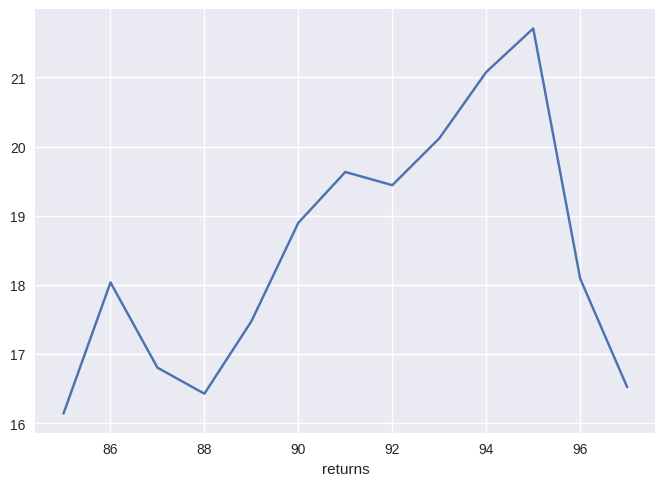

In [21]:
many_results.groupby("returns").performance.mean().plot()
plt.show()

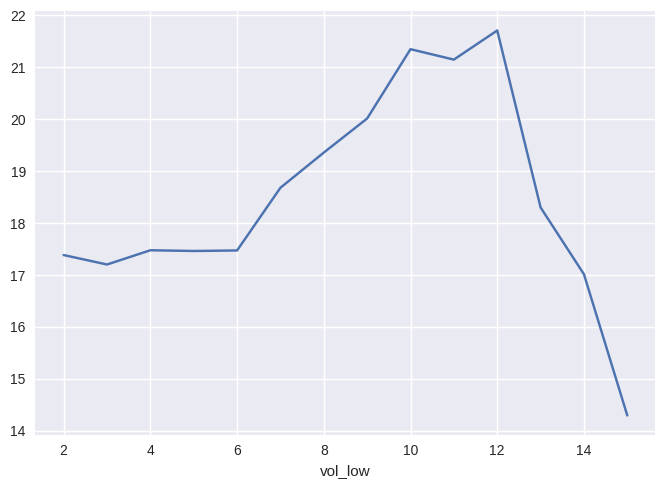

In [22]:
many_results.groupby("vol_low").performance.mean().plot()
plt.show()

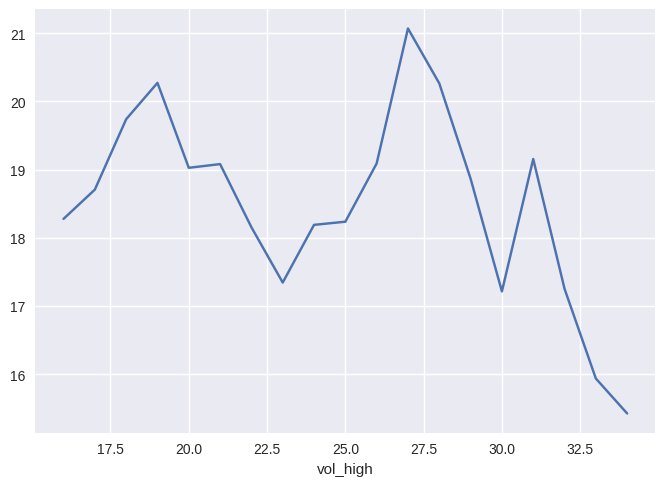

In [23]:
many_results.groupby("vol_high").performance.mean().plot()
plt.show()

In [24]:
backtest(data = data, parameters = (94, 11, 27), tc = -0.00085)

np.float64(28.607622816622424)

In [25]:
backtest(data = data, parameters = (90, 5, 20), tc = -0.00085)

np.float64(19.056162979544915)

## Putting everything together: a Backtester Class

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

__Why using OOP and creating a class?__

- Organizing/Storing/Linking all Functionalities and the Code in one Place/Class (managing/reducing complexity)
- Reusability of Code
- Framework for many other Strategies (only few adjustment required)

Note: You can find a __detailed Tutorial__ on OOP & Classes in the __Appendix__ (at the end of this course).

In [27]:
class Long_Only_Backtester():
    ''' Class for the vectorized backtesting of simple Long-only trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Only_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, percentiles = None, thresh = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        percentiles: tuple (return_perc, vol_low_perc, vol_high_perc)
            return and volume percentiles to be considered for the strategy.
            
        thresh: tuple (return_thresh, vol_low_thresh, vol_high_thesh)
            return and volume thresholds to be considered for the strategy.
        '''
        
        self.prepare_data(percentiles = percentiles, thresh = thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, percentiles, thresh):
        ''' Prepares the Data for Backtesting.
        '''
        
        data = self.data[["Close", "Volume", "returns"]].copy()
        data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
        data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
        data.loc[data.vol_ch < -3, "vol_ch"] = np.nan        
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), percentiles[0])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), [percentiles[1], percentiles[2]])
        elif thresh:
            self.return_thresh = thresh[0]
            self.volume_thresh = [thresh[1], thresh[2]]
                
        cond1 = data.returns >= self.return_thresh
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        
        data["position"] = 1
        data.loc[cond1 & cond2, "position"] = 0

        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, return_range, vol_low_range, vol_high_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        return_range: tuple
            tuples of the form (start, end, step size).
            
        vol_low_range: tuple
            tuples of the form (start, end, step size).
        
        vol_high_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        return_range = range(*return_range)
        vol_low_range = range(*vol_low_range)
        vol_high_range = range(*vol_high_range)
        
        combinations = list(product(return_range, vol_low_range, vol_high_range))
        
        performance = []
        for comb in combinations:
            self.prepare_data(percentiles = comb, thresh = None)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["returns", "vol_low", "vol_high"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        return_perc = best.returns.iloc[0]
        vol_perc = [best.vol_low.iloc[0], best.vol_high.iloc[0]]
        perf = best.performance.iloc[0]
        print("Return_Perc: {} | Volume_Perc: {} | {}: {}".format(return_perc, vol_perc, self.metric, round(perf, 5))) 
        self.test_strategy(percentiles = (return_perc, vol_perc[0], vol_perc[1]))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = {} | THRESHOLDS = {}, {}".format(self.symbol, np.round(self.return_thresh, 5), np.round(self.volume_thresh, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)


In [ ]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2021-10-07"
tc = -0.00085

In [ ]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [ ]:
tester

In [ ]:
tester.data

In [ ]:
tester.test_strategy(percentiles = (90, 5, 20))

In [ ]:
tester.plot_results()

In [ ]:
tester.results

In [ ]:
return_thresh = tester.return_thresh
return_thresh

In [ ]:
volume_thresh = tester.volume_thresh
volume_thresh

In [ ]:
tester.test_strategy(thresh = (return_thresh, volume_thresh[0], volume_thresh[1]))

In [ ]:
tester.optimize_strategy(return_range = (85, 98, 1), 
                         vol_low_range = (2, 16, 1), 
                         vol_high_range = (16, 35, 1))

In [ ]:
tester.results_overview.nlargest(20, "performance")

In [ ]:
tester.results

In [ ]:
tester.plot_results()

## Backtesting & Forward Testing (Part 1)

__Great Backtesting Results - Too good to be true?__

Two major Problems: 

- __Data Snooping / "Over-Optimization"__ -> Will these parameters work with new/fresh data as well? <br>
- __Look-Ahead-Bias__ -> we know all future price and volume data from day 1 to calculate percentiles/thresholds. 

__Will this strategy outperform Buy-and-Hold in the Future?__

- wait months/year(s) and analyze then (not an option)
- split past data into __Backtesting Set__ (optimize Strategy) and __Forward Testing Set__ (test optimized Strategy on fresh data)

__Backtesting & Optimization (until the end of 2020)__

In [ ]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-12-31"
tc = -0.00085

In [ ]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.optimize_strategy((85, 98, 1), (2, 16, 1), (16, 35, 1))

In [ ]:
many_results = tester.results_overview
many_results

In [ ]:
many_results.groupby("returns").performance.mean().plot()
plt.show()

In [ ]:
many_results.groupby("vol_low").performance.mean().plot()
plt.show()

In [ ]:
many_results.groupby("vol_high").performance.mean().plot()
plt.show()

In [ ]:
tester.test_strategy((94, 11, 28))

In [ ]:
tester.plot_results()

In [ ]:
return_thresh = tester.return_thresh
return_thresh

In [ ]:
volume_thresh = tester.volume_thresh
volume_thresh

__Forward Testing (starting at 2021-01-01)__

we need: thresholds from backtesting

In [ ]:
return_thresh

In [ ]:
volume_thresh

In [ ]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2021-01-01"
end = "2021-10-7"
tc = -0.00085

In [ ]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester

In [ ]:
tester.test_strategy(thresh = (return_thresh, volume_thresh[0], volume_thresh[1]))

In [ ]:
tester.plot_results()

In [ ]:
tester.results.position.value_counts()

__Reasons for Performance Difference between Backtesting and Forward Testing:__

- Data Snooping / Over-Optimization (partly)
- Look-Ahead-Bias (partly)

In [ ]:
tester.optimize_strategy((85, 98, 1), (5, 15, 1), (15, 35, 1))

In [ ]:
tester.plot_results()

- Overall Regime Change (Patterns can change over time)
- Strategy not powerful enough